<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation4_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the fourth dataset

We first need to load the dataset. 

In [17]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/cam.py -P local_modules -nc
!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/utils/visualize.py -P local_modules -nc
import sys
sys.path.append('local_modules')
from PIL import Image
from local_modules.visualize import visualize
import local_modules.cam as smooth

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/Hshapley.py -P local_modules -nc
import local_modules.Hshapley as HS

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (6,5)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/cam.py’ already there; not retrieving.

File ‘local_modules/visualize.py’ already there; not retrieving.

File ‘local_modules/Hshapley.py’ already there; not retrieving.



Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [3]:
#@title
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 4)
    self.pool2 = nn.MaxPool2d(kernel_size = 5)
    self.fc1 = nn.Linear(in_features = 16*9*11, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model4_random.pth')) 

<All keys matched successfully>

Now, load and format the images we want to test the network's decision on. 

In [0]:
#@title
transf = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

im = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/random_4", transform = transf)
batch_Size = 3
dataloader = DataLoader(im, batch_size = batch_Size, shuffle = False, num_workers = 0)
data = iter(dataloader)
images, labels = next(data)

idx_to_class = {j:i for i,j in im.class_to_idx.items()}

For this dataset, we should import two images with label 0, because a label 0 can be attributed for two different reasons: 
- absence of a black circle 
- presence of a cross 

Let's first do one with crosses. 

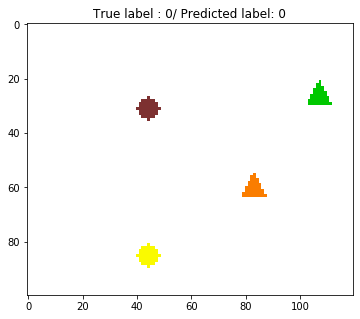

In [5]:
image0 = images[0]
label0 = labels[0]

input0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 
outputs = net(input0)
_, predicted0 = torch.max(outputs.data, 1)

def denormalize(im): 
  return im*0.5 + 0.5

def make_showable(im, denorm = True): 
  im_showable = im.numpy().transpose(1,2,0)
  if (denorm): 
    im_showable = denormalize(im_showable)
  return im_showable

def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  im = make_showable(image)
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[int(true_label)]
  if (predicted_label != None):
    title_ += "/ Predicted label: " + idx_to_class[predicted_label]
  plt.title(title_)

display_image(image0, label0, int(predicted0))

This image was correctly labeled as a 0, because it contains crosses (even though there is a black circle). 

What parts in the input were considered important by the network to make this call ? 

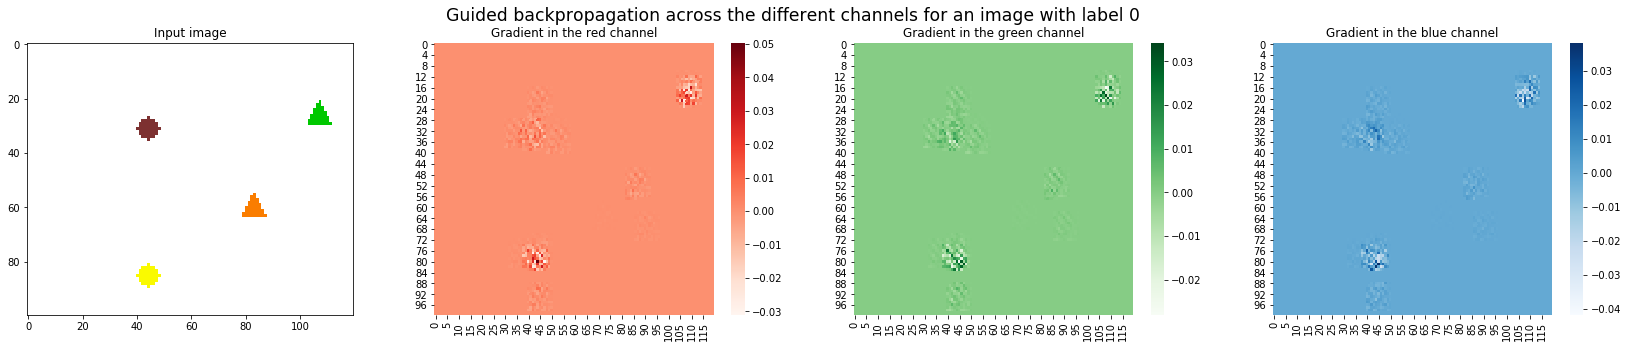

In [6]:
input0.requires_grad = True # Necessary to compute the gradient
backprop = Backprop(net)
gradients0 = backprop.calculate_gradients(input0, label0, guided = True)

def display_image_and_gradients(image, gradients): 
  fig = plt.figure(figsize = (4*FIGSIZE[0]*1.2, FIGSIZE[1]))
  ax0 = fig.add_subplot(141, title = "Input image")
  ax1 = fig.add_subplot(142, title = "Gradient in the red channel")
  ax2 = fig.add_subplot(143, title = "Gradient in the green channel")
  ax3 = fig.add_subplot(144, title = "Gradient in the blue channel")
  ax0.imshow(make_showable(image))
  _ = sns.heatmap(gradients[0], cmap="Reds", ax = ax1)
  _ = sns.heatmap(gradients[1], cmap="Greens", ax = ax2)
  _ = sns.heatmap(gradients[2], cmap="Blues", ax = ax3)
  return fig

display_image_and_gradients(image0, gradients0.detach().numpy()).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");

Crosses and the black circle are most relevant, but the input region of the grey square also seems to matter. There is no color dependence, since black depends as much on the value of each channel. 

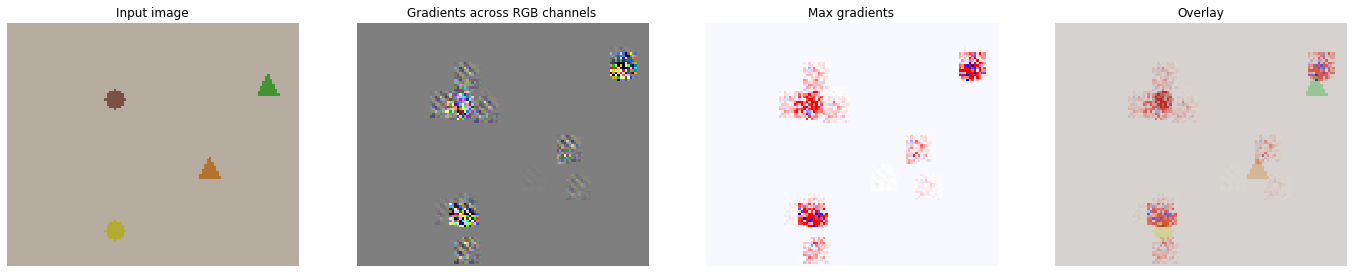

In [7]:
#@title
backprop.visualize(input0, label0, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

Now, one with no black circles.

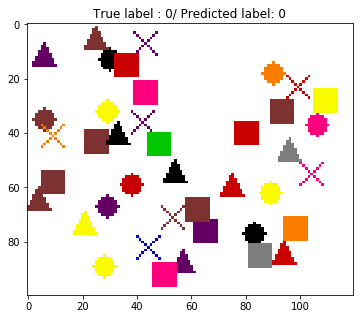

In [8]:
image1 = images[1]
label1 = labels[1]

input1 = image1.view(-1, 3, 100, 120)
outputs = net(input1)
_, predicted1 = torch.max(outputs.data, 1)

display_image(image1, label1, int(predicted1))

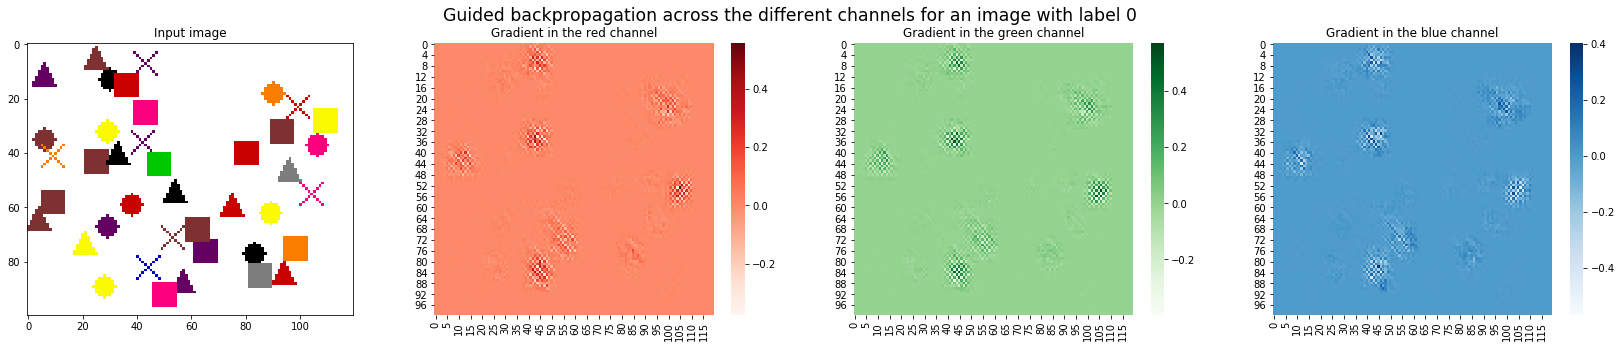

In [9]:
input1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(input1, label1)
display_image_and_gradients(image1, gradients1.detach().numpy()).suptitle("Guided backpropagation across the different channels for an image with label 0 ", size="xx-large");

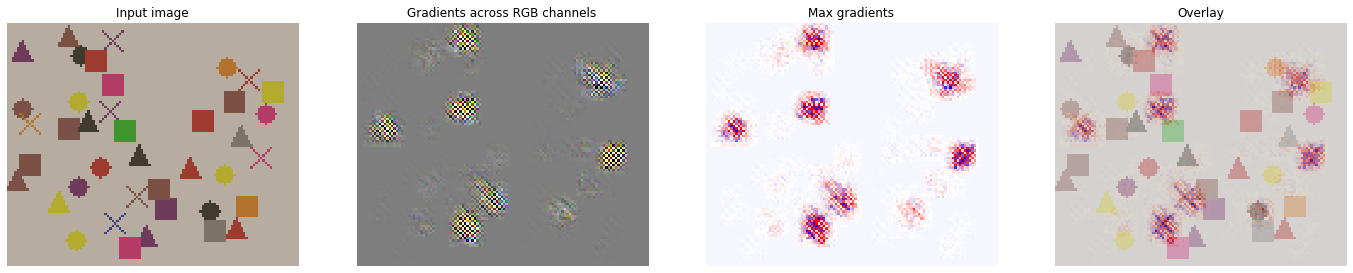

In [10]:
#@title
backprop.visualize(input1, label1, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap = 'bwr')

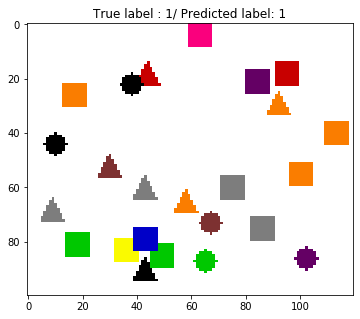

In [11]:
image2 = images[2]
label2 = labels[2]

input2 = image2.view(-1, 3, 100, 120)
outputs = net(input2)
_, predicted2 = torch.max(outputs.data, 1)

display_image(image2, label2, int(predicted2))

This image was correctly labeled as a 1, because it contains a black circle but no crosses.

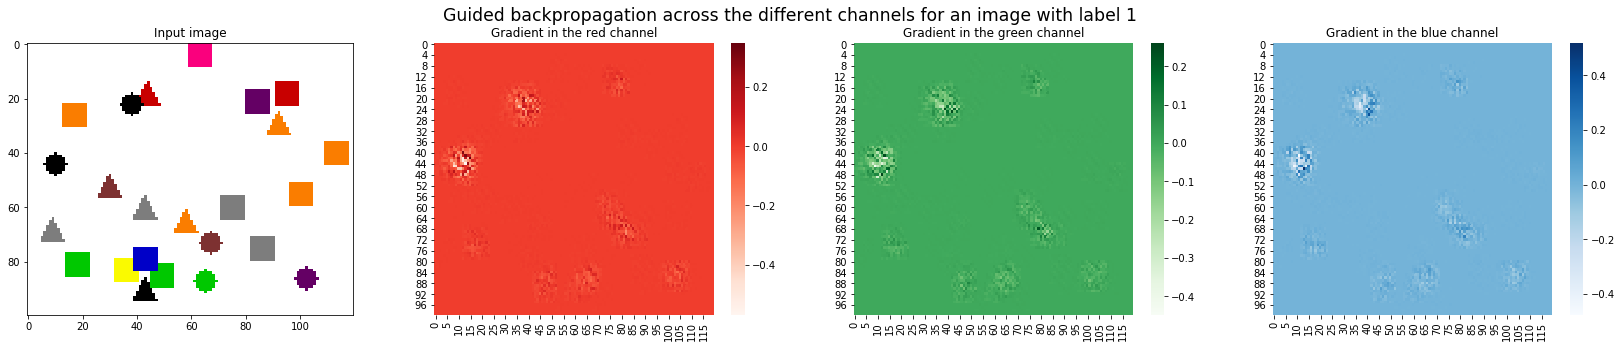

In [12]:
input2.requires_grad = True # Necessary to compute the gradient
gradients2 = backprop.calculate_gradients(input2, label2)
display_image_and_gradients(image2, gradients2.detach().numpy()).suptitle("Guided backpropagation across the different channels for an image with label 1 ", size="xx-large");

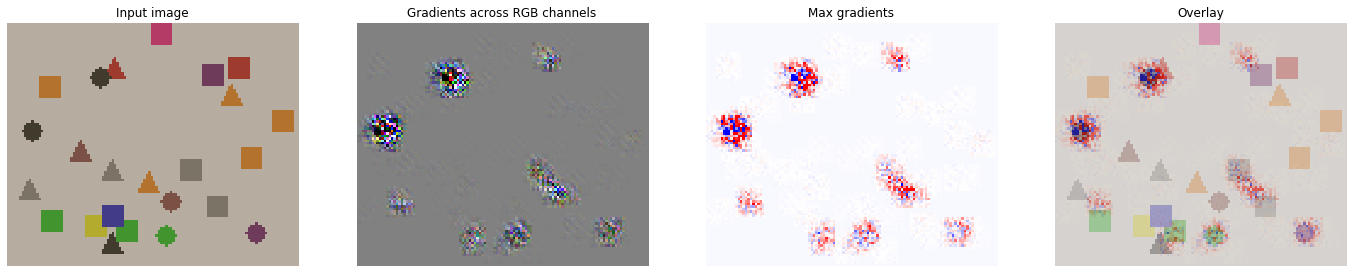

In [13]:
#@title
backprop.visualize(input2, label2, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap = 'bwr')

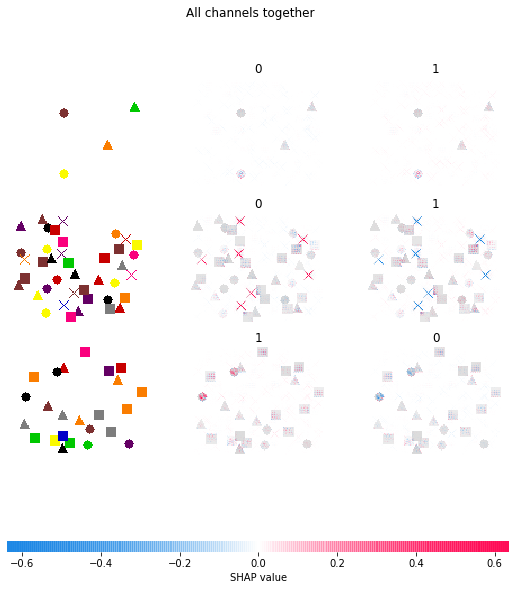

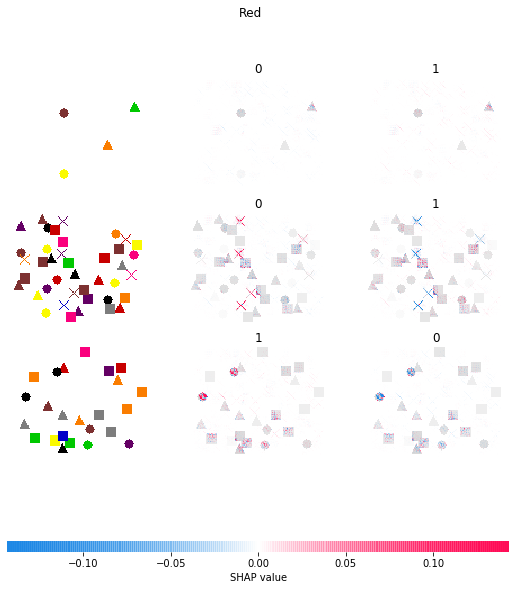

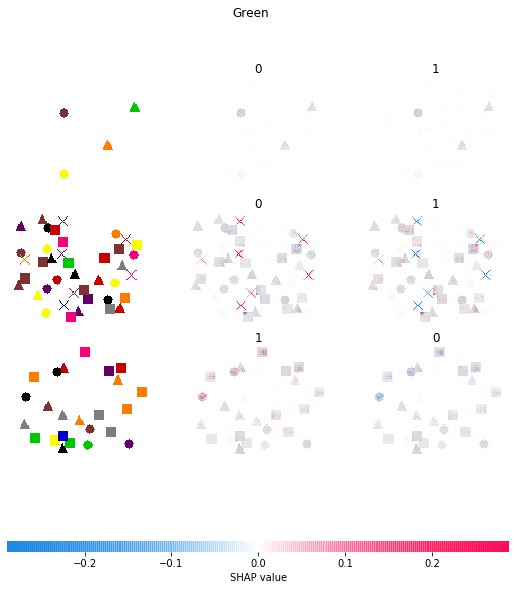

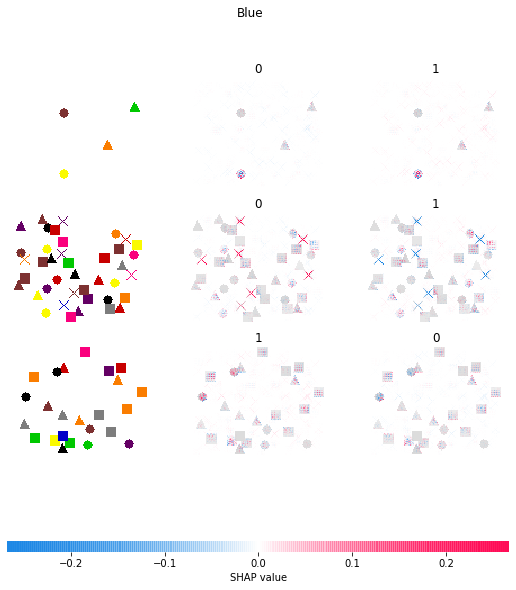

In [14]:
#@title
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data4/random.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = 50, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)
X,Y = next(train_loader)

bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X

if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)

to_explain = images

e = shap.GradientExplainer(net, background)

shap_values,indexes = e.shap_values(to_explain, ranked_outputs=2, nsamples=200)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]


to_explain = np.swapaxes(to_explain,1,2)
to_explain = np.swapaxes(to_explain,2,3)
#to_explain[:,:,:,1] = -0.1*torch.ones(2,100,120)

images_plot = (denormalize(to_explain.numpy()))

shap_red = [shap_values[0][:,:,:,0], shap_values[1][:,:,:,0]]
shap_green = [shap_values[0][:,:,:,1], shap_values[1][:,:,:,1]]
shap_blue = [shap_values[0][:,:,:,2], shap_values[1][:,:,:,2]]

shap.image_plot(shap_values, images_plot, indexes.numpy(), show = False)
plt.suptitle("All channels together");
shap.image_plot(shap_red, images_plot, indexes.numpy(), show = False)
plt.suptitle("Red");
shap.image_plot(shap_green, images_plot, indexes.numpy(), show = False)
plt.suptitle("Green");
shap.image_plot(shap_blue, images_plot, indexes.numpy(), show = False)
plt.suptitle("Blue");

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.


Second convolutional layer
Second pooling layer


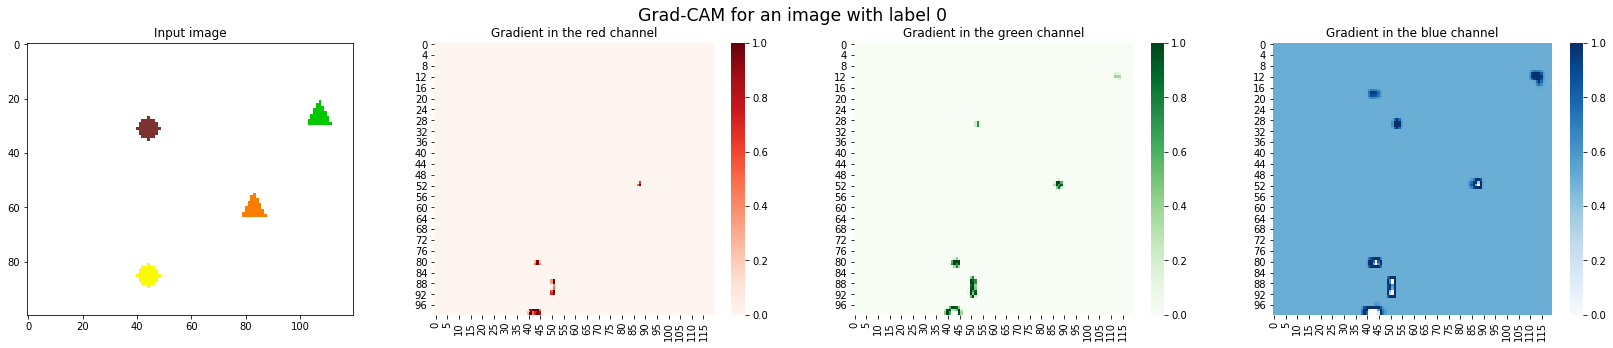

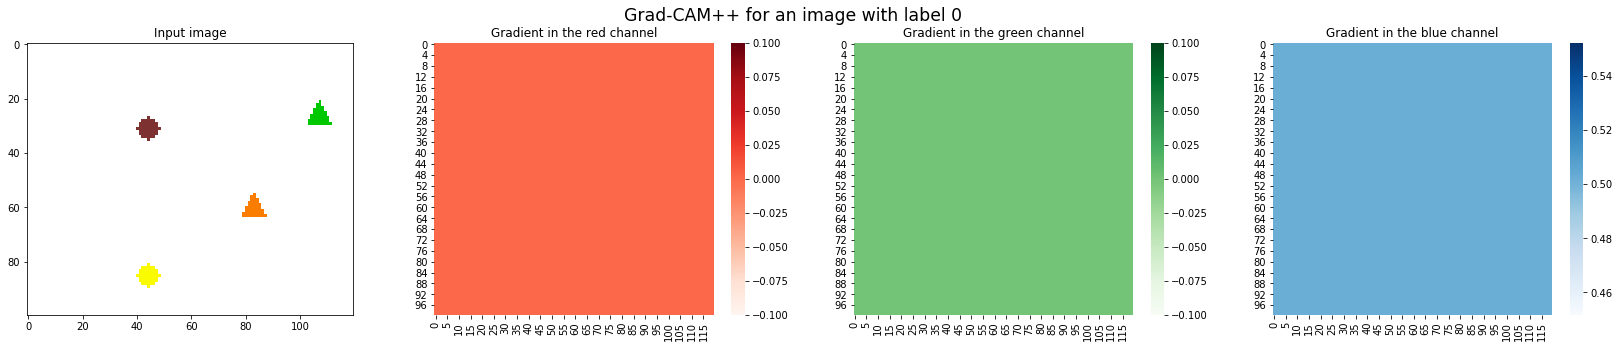

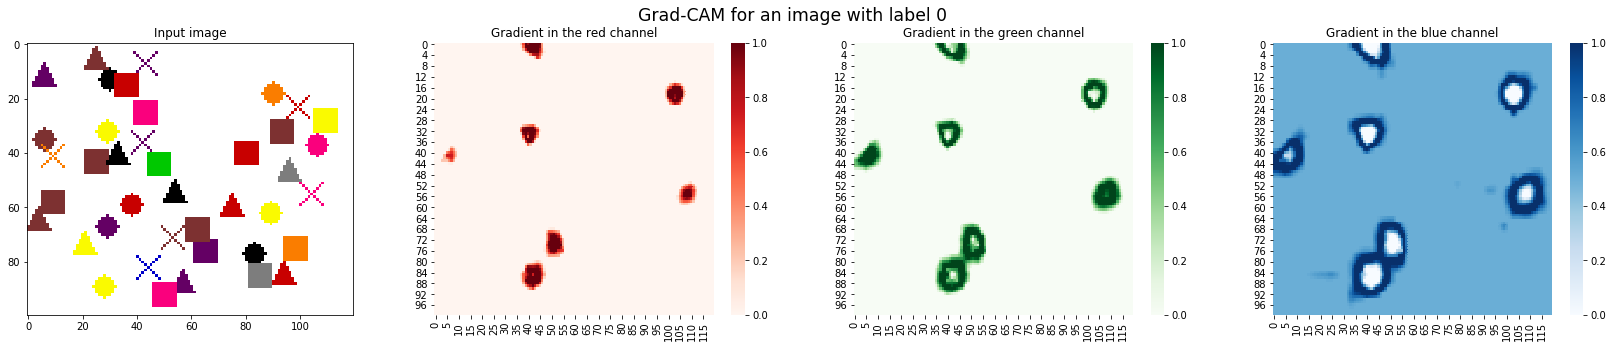

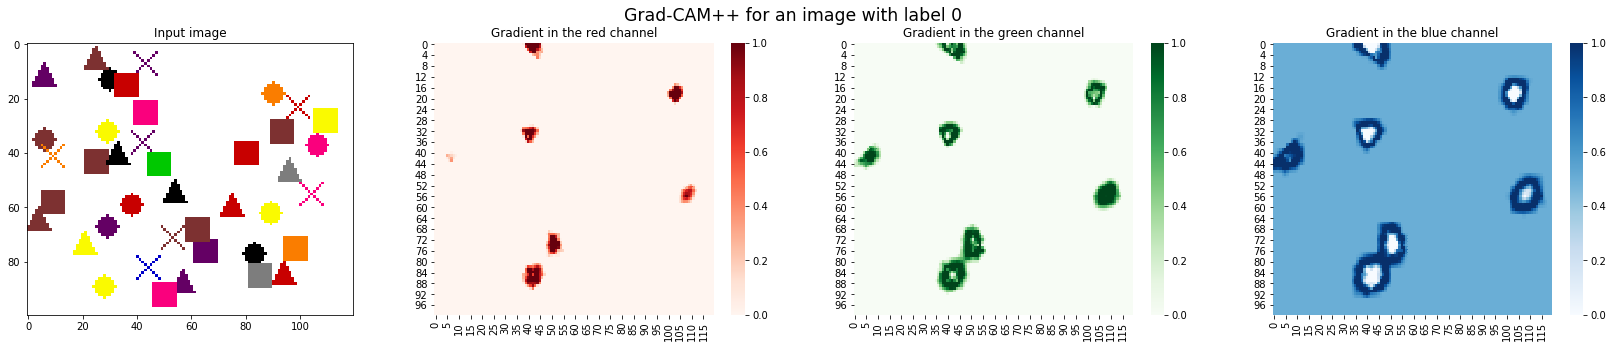

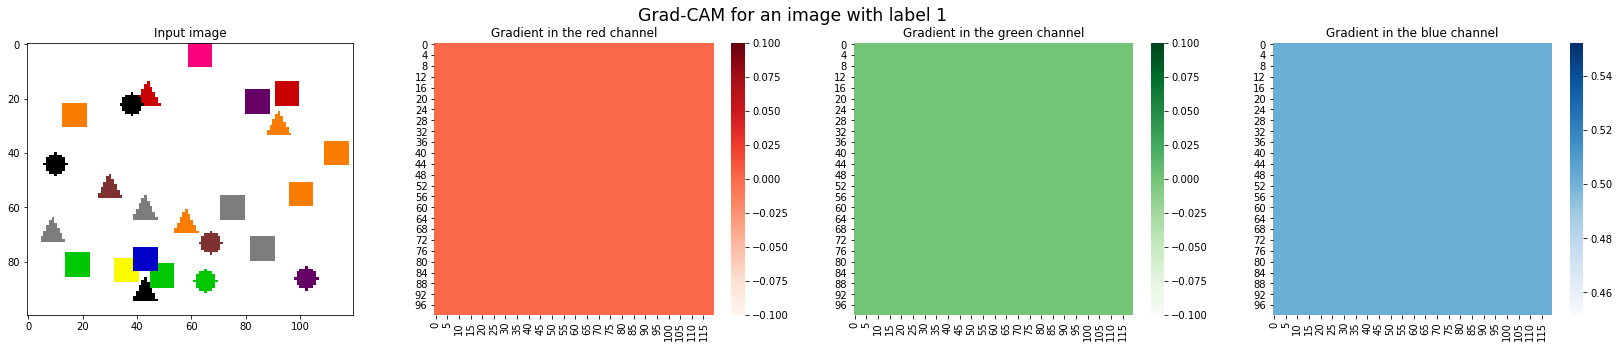

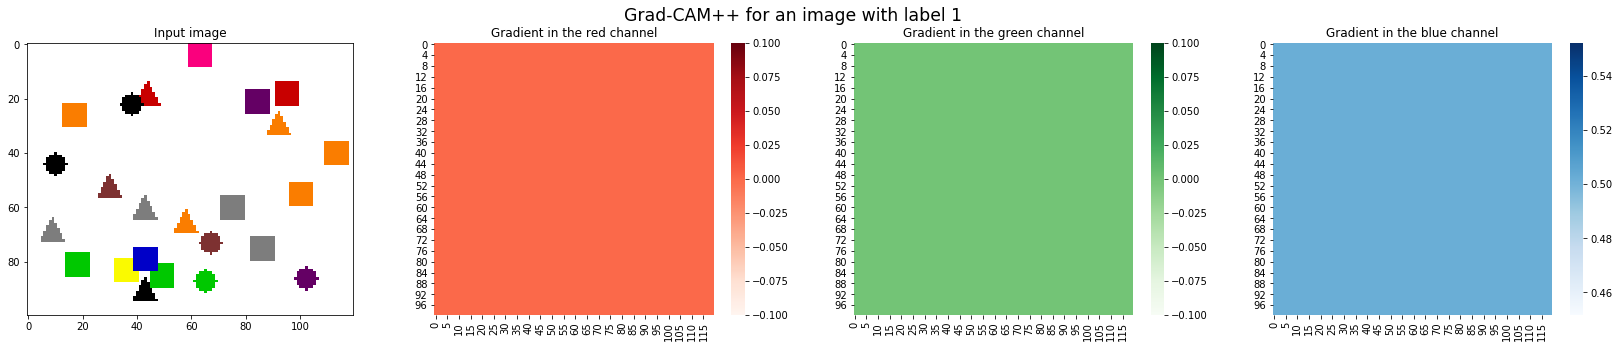

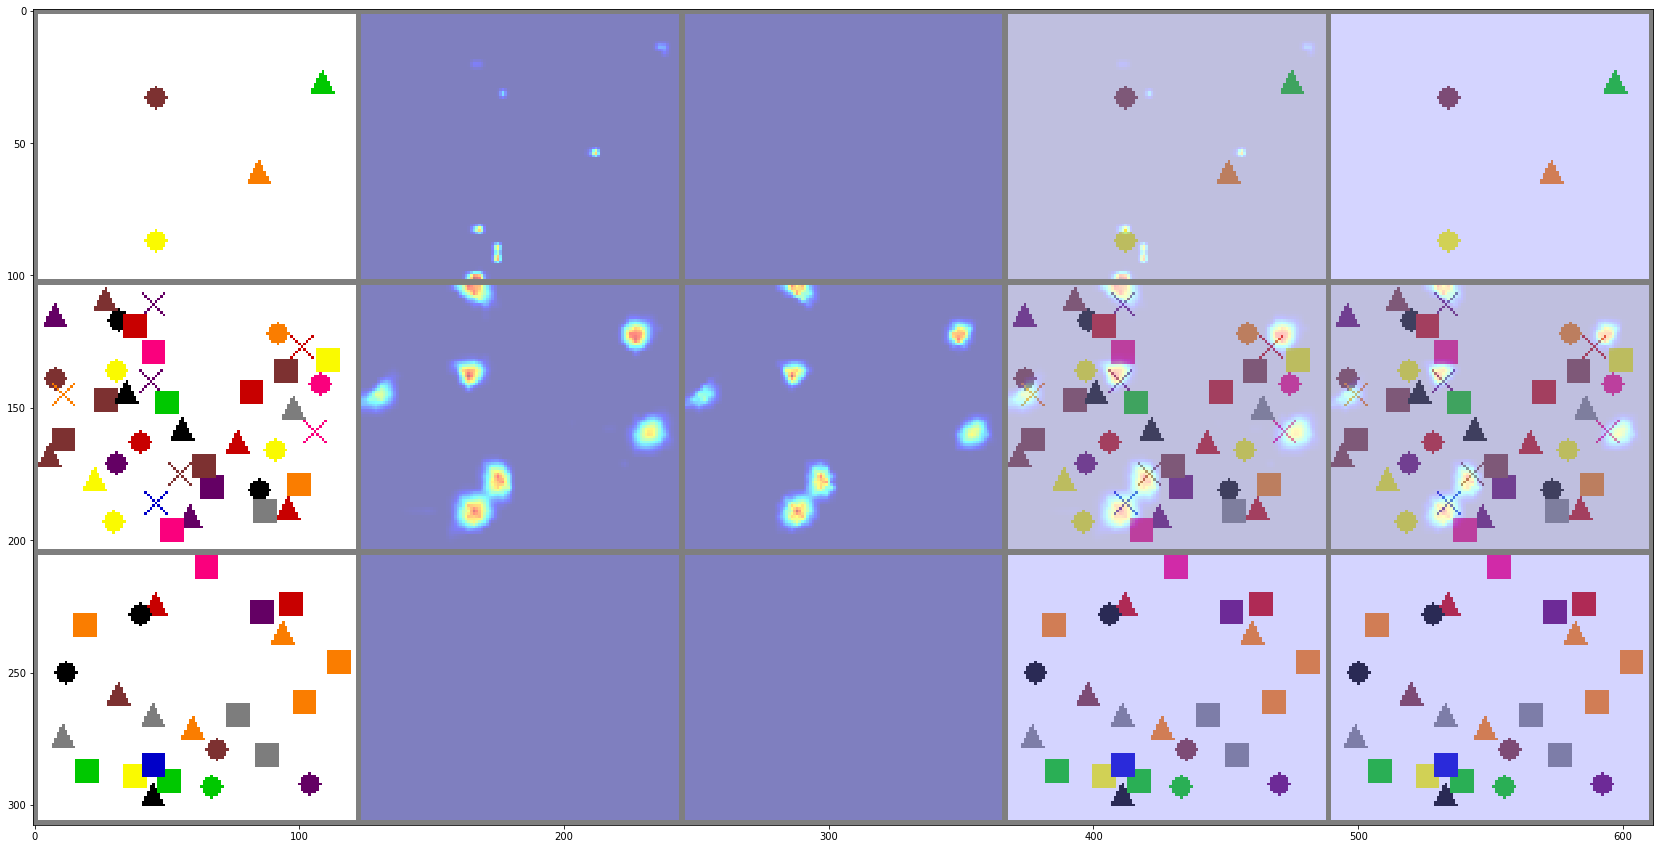

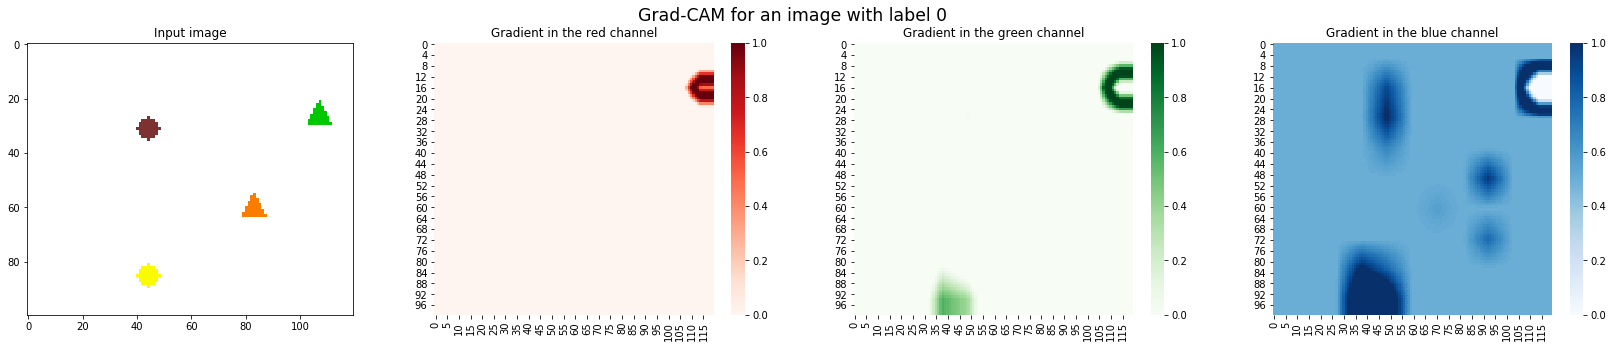

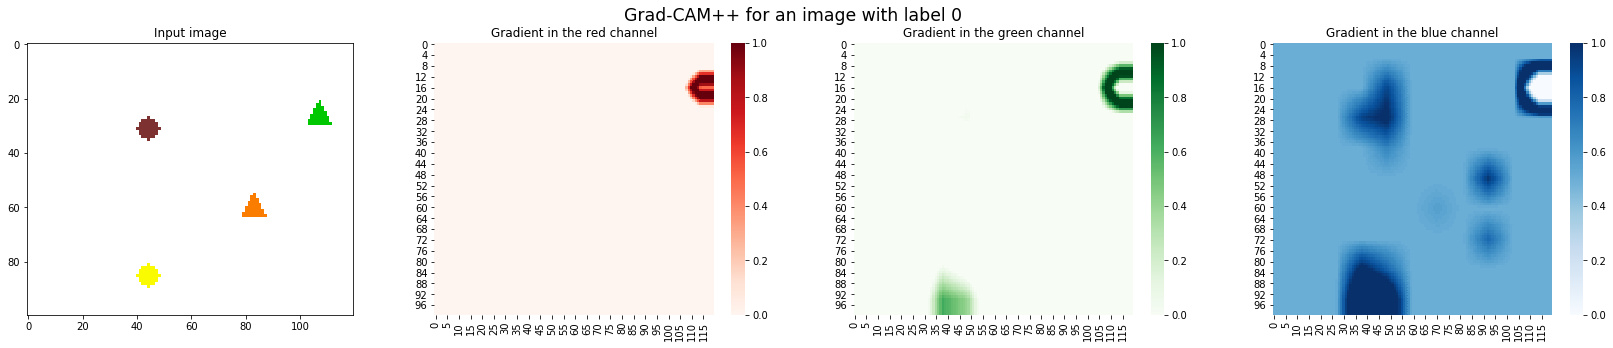

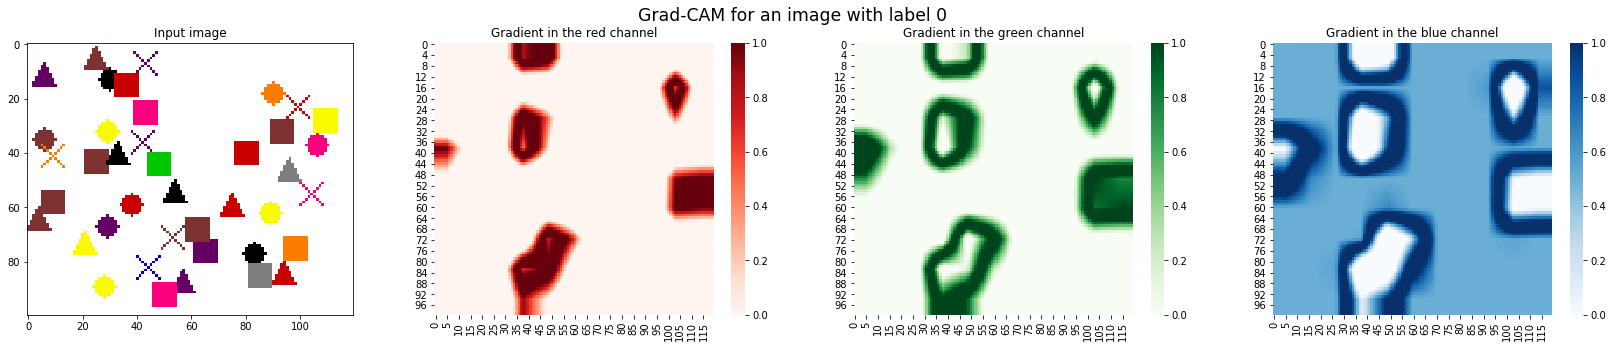

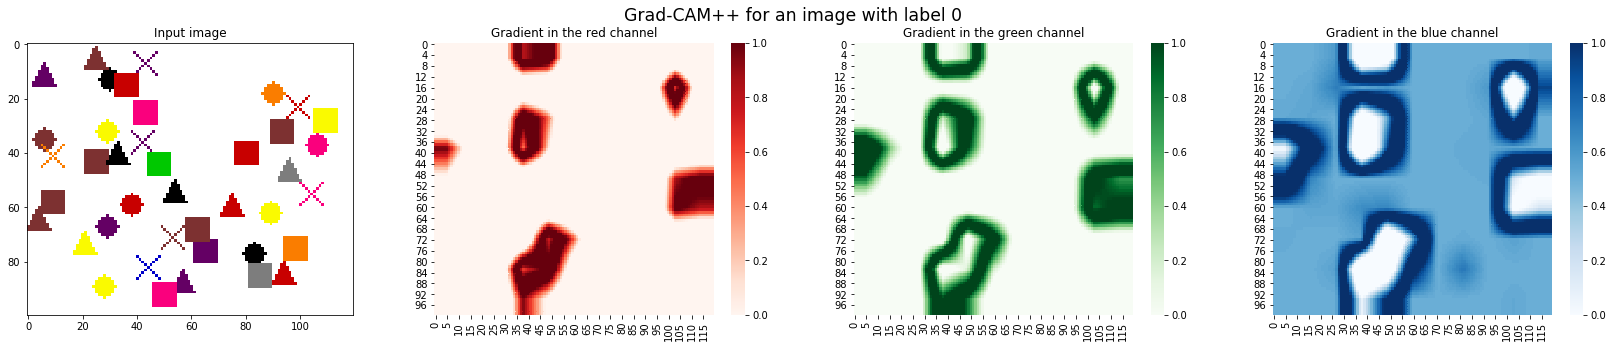

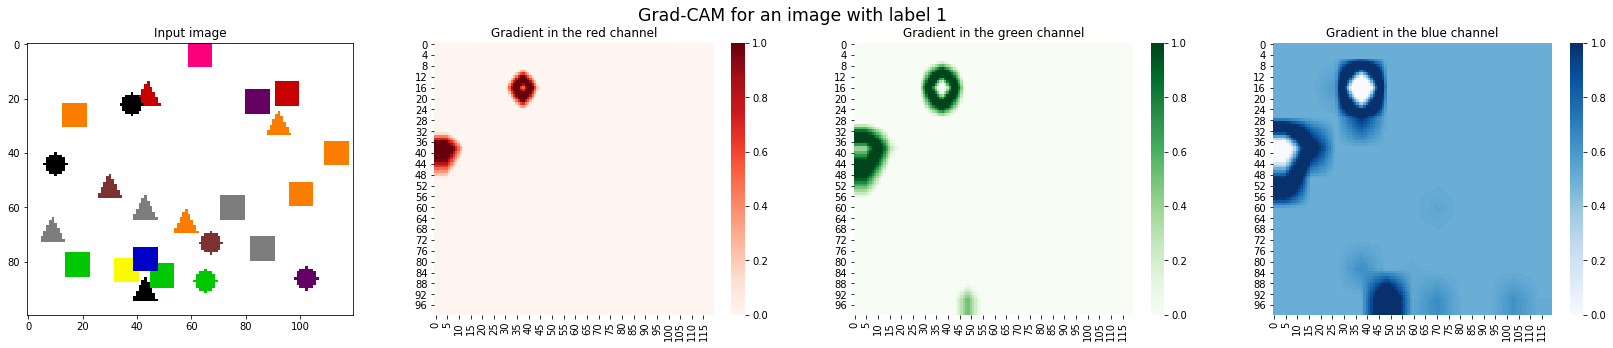

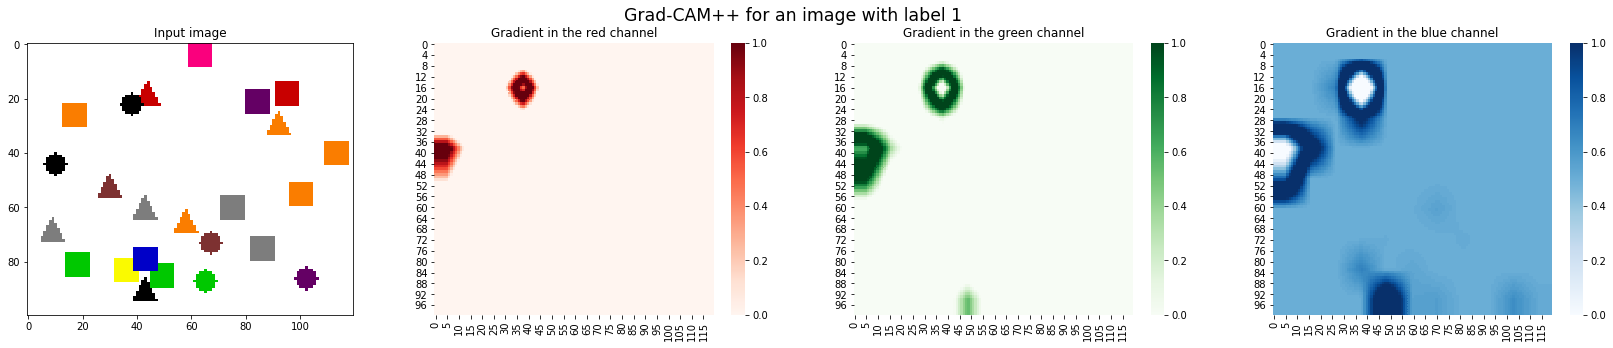

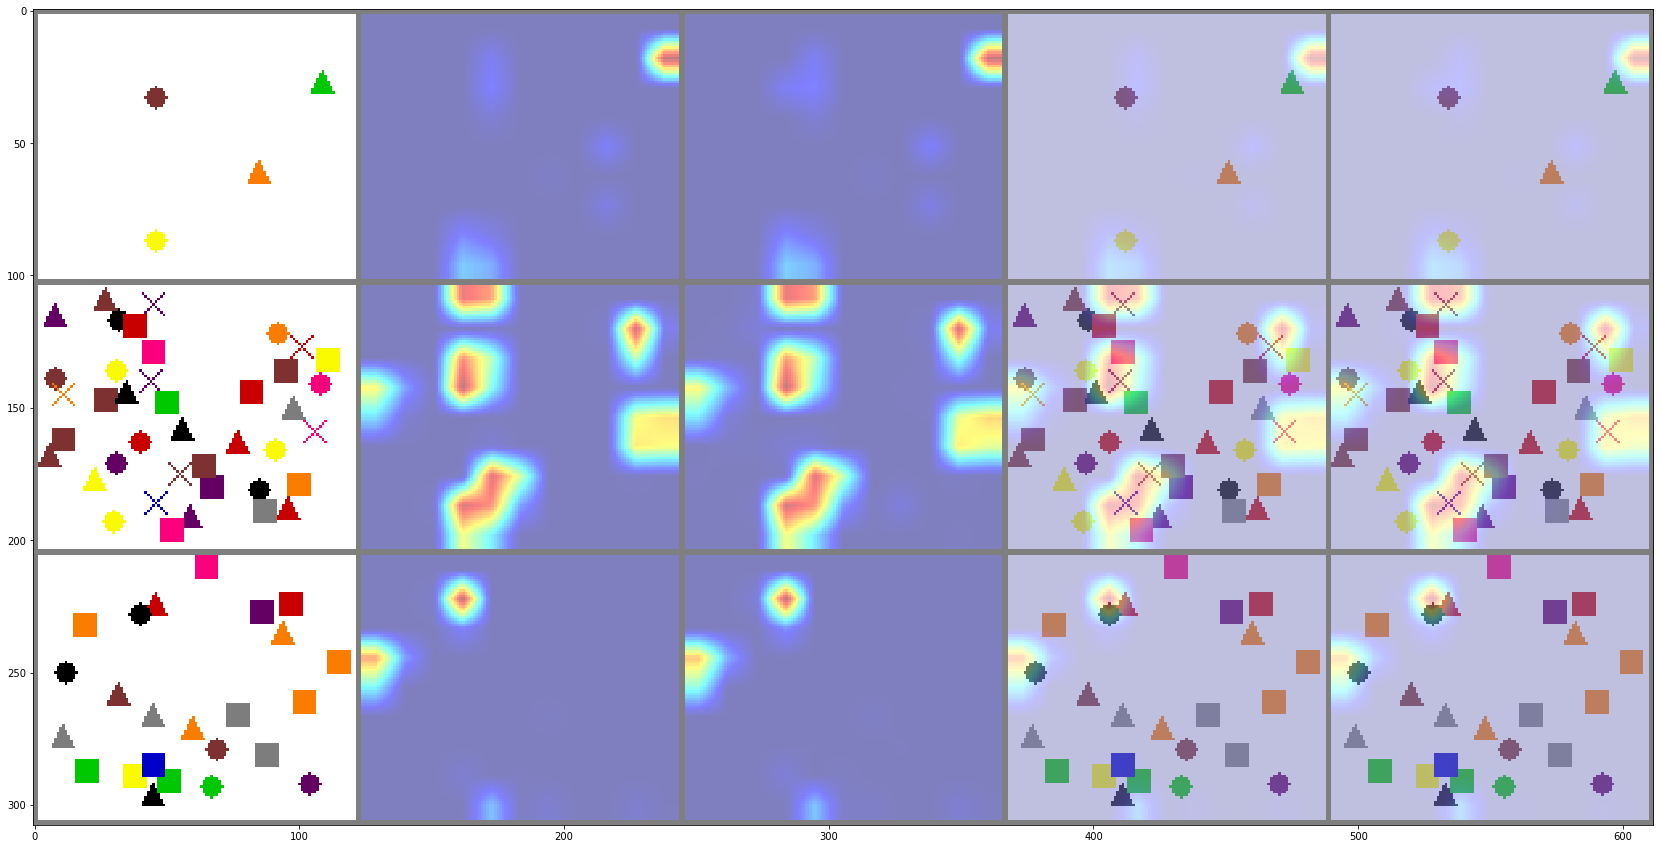

In [15]:
layers = [net.conv2, net.pool2]
names = ["Second convolutional layer", "Second pooling layer"]

for i in range(len(layers)): 
  target_layer = layers[i]
  gradcam = GradCAM(net, target_layer)
  gradcam_pp = GradCAMpp(net, target_layer)

  mask0, _ = gradcam(input0)
  heatmap0, result0 = visualize_cam(mask0, input0)
  mask_pp0, _ = gradcam_pp(input0)
  heatmap_pp0, result_pp0 = visualize_cam(mask_pp0, input0)

  mask1, _ = gradcam(input1)
  heatmap1, result1 = visualize_cam(mask1, input1)
  mask_pp1, _ = gradcam_pp(input1)
  heatmap_pp1, result_pp1 = visualize_cam(mask_pp1, input1)

  mask2, _ = gradcam(input2)
  heatmap2, result2 = visualize_cam(mask2, input2)
  mask_pp2, _ = gradcam_pp(input2)
  heatmap_pp2, result_pp2 = visualize_cam(mask_pp2, input2)

  print(names[i])
  display_image_and_gradients(image0, heatmap0.detach().numpy()).suptitle("Grad-CAM for an image with label 0", size="xx-large")
  display_image_and_gradients(image0, heatmap_pp0.detach().numpy()).suptitle("Grad-CAM++ for an image with label 0", size="xx-large")
  display_image_and_gradients(image1, heatmap1.detach().numpy()).suptitle("Grad-CAM for an image with label 0", size="xx-large")
  display_image_and_gradients(image1, heatmap_pp1.detach().numpy()).suptitle("Grad-CAM++ for an image with label 0", size="xx-large")
  display_image_and_gradients(image2, heatmap2.detach().numpy()).suptitle("Grad-CAM for an image with label 1", size="xx-large")
  display_image_and_gradients(image2, heatmap_pp2.detach().numpy()).suptitle("Grad-CAM++ for an image with label 1", size="xx-large")

  I = []
  I.extend([image0, heatmap0, heatmap_pp0, result0, result_pp0])
  I.extend([image1, heatmap1, heatmap_pp1, result1, result_pp1])
  I.extend([image2, heatmap2, heatmap_pp2, result2, result_pp2])


  grid_image = make_grid(I, nrow=5)

  fig, ax = plt.subplots(figsize=(5*FIGSIZE[0], 3*FIGSIZE[1]))
  ax.imshow(make_showable(grid_image.detach()))

NEWINPUT
predicted class ids 0	 probability 0.9993724226951599
predicted class ids 0	 probability 0.9993724226951599
predicted class ids 0	 probability 0.9998334646224976
NEWINPUT
predicted class ids 0	 probability 1.0
predicted class ids 0	 probability 1.0
predicted class ids 0	 probability 1.0


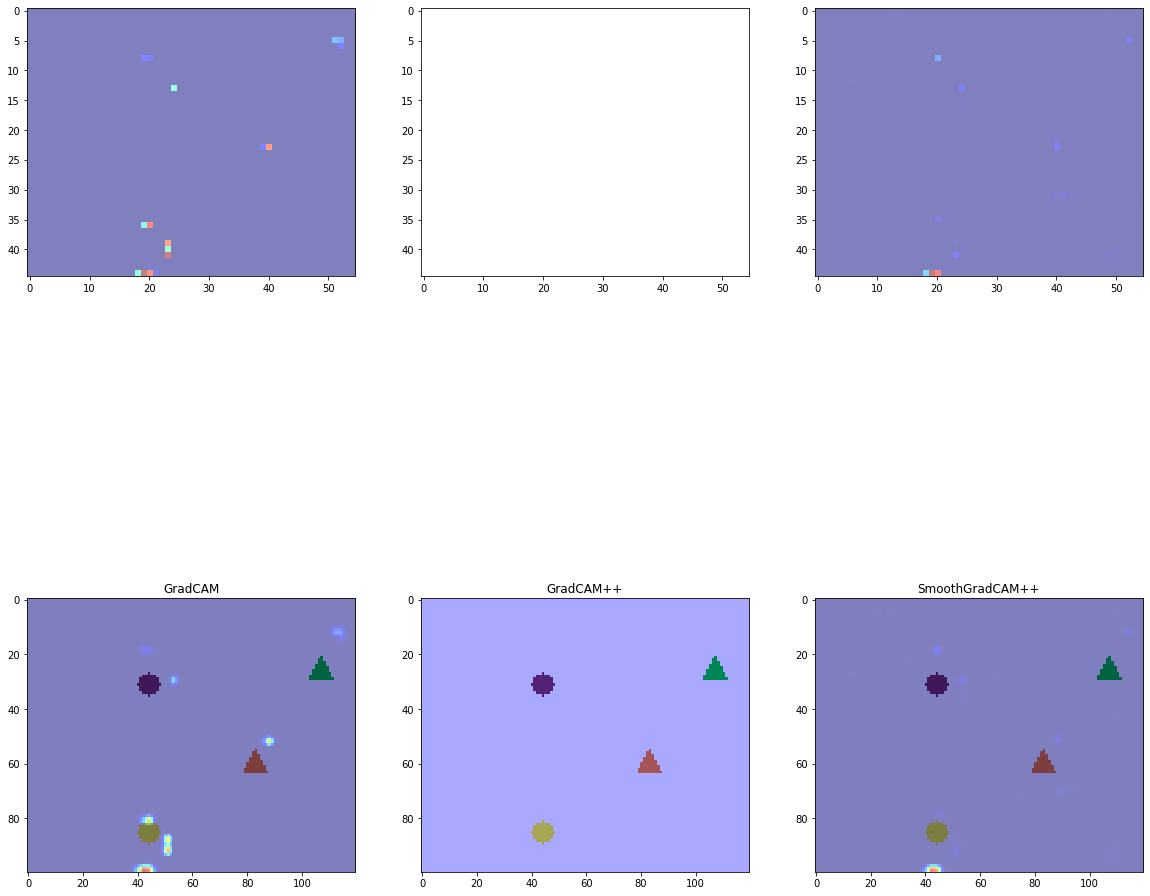

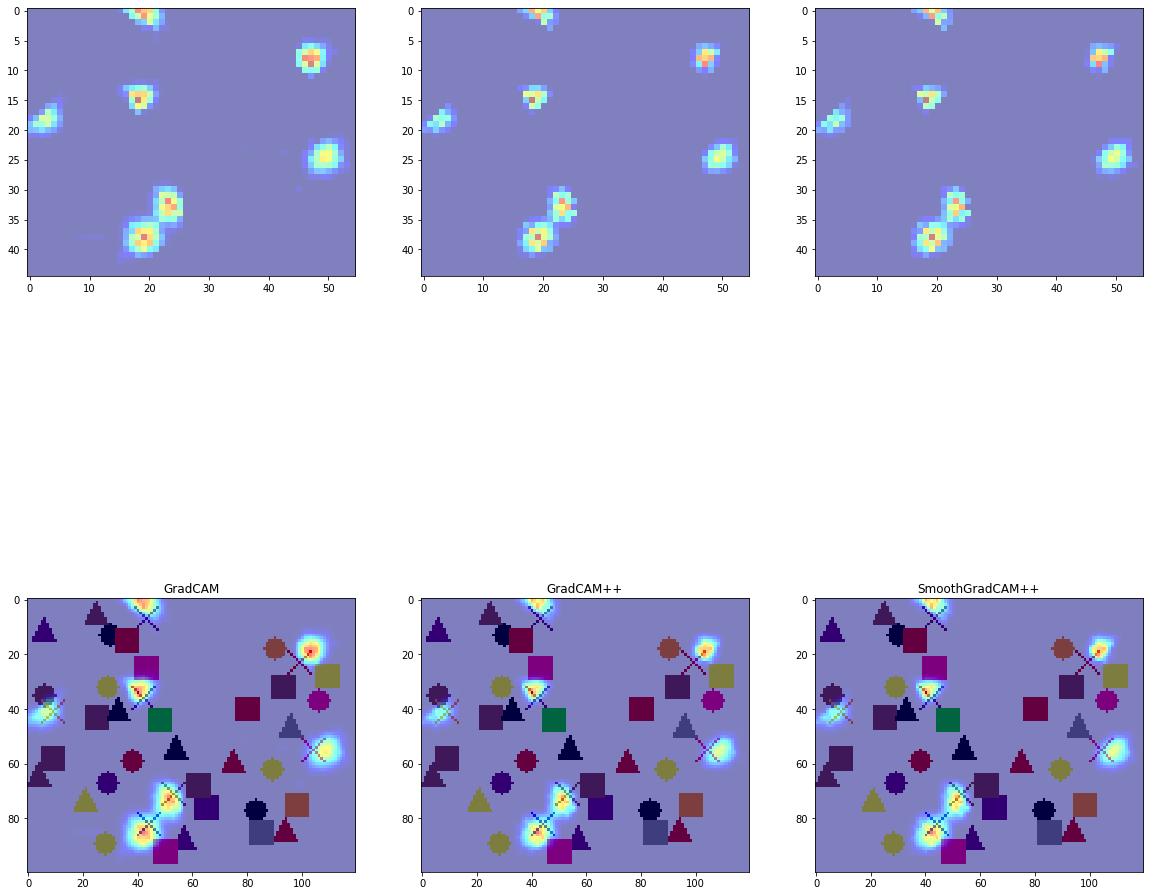

In [16]:
target_layer = net.conv2
wrapped_G = smooth.GradCAM(net, target_layer)
wrapped_P = smooth.GradCAMpp(net, target_layer)
wrapped_S = smooth.SmoothGradCAMpp(net, target_layer, n_samples=25, stdev_spread=0.15)
wrapped = [wrapped_G, wrapped_P, wrapped_S]
titles = ["GradCAM","GradCAM++","SmoothGradCAM++"]
for inp in [input0, input1]: 
  print("NEWINPUT")
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
  for i in range(len(wrapped)): 
    cam, idx = wrapped[i](inp)
    img = denormalize(inp)
    heatmap = visualize(img, cam)
    hm = (heatmap.squeeze().detach().numpy().transpose(1, 2, 0))
    ax[0][i].imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
    ax[1][i].imshow(hm)
    ax[1][i].set_title(titles[i])

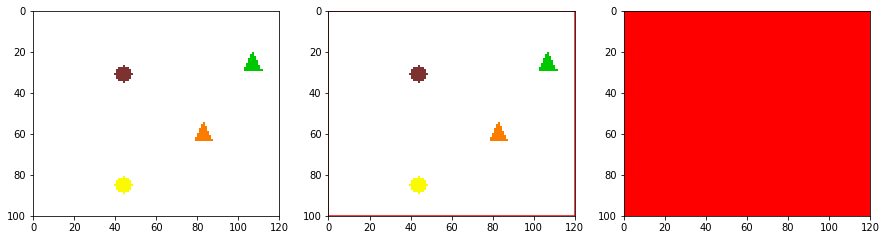

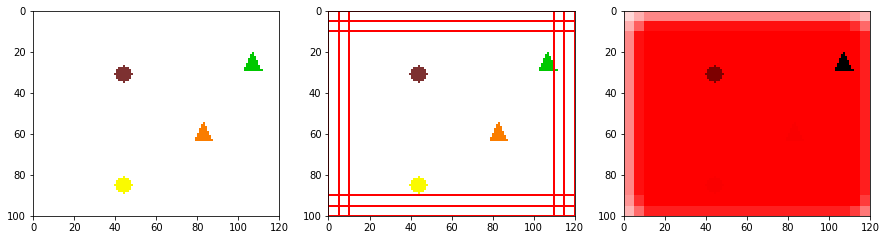

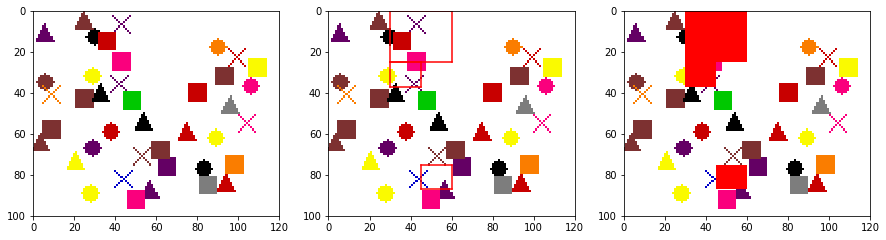

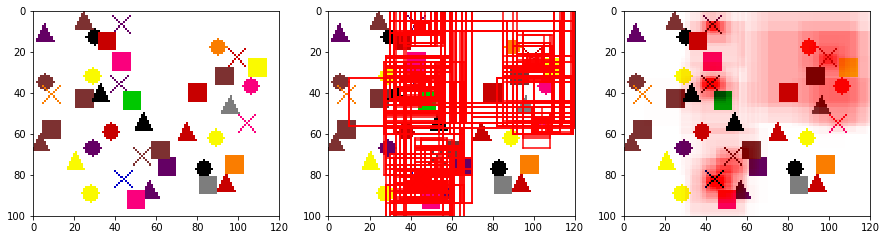

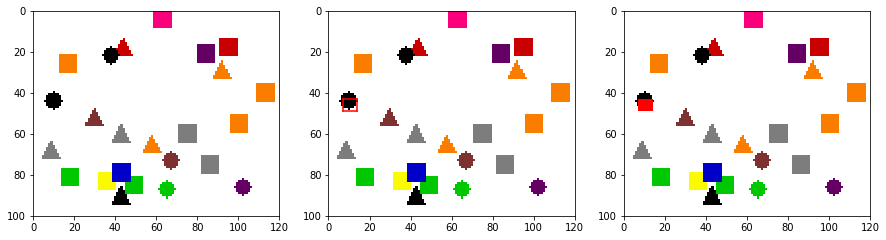

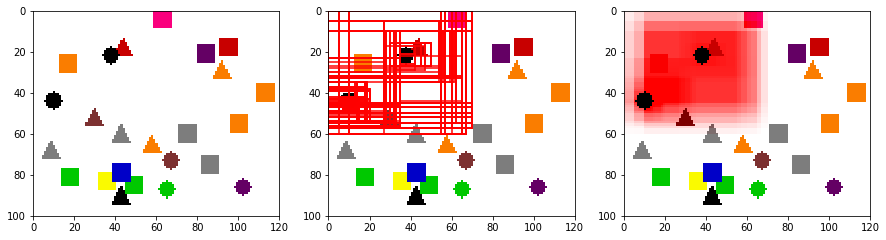

In [18]:
h = HS.HierarchicalShap(net)
h.shapMap(image0, label0, shapTol = [6], keepItSimple = True)
h.shapMap(image0, label0, shapTol = [5,5.5,6,6.5,7])
h.shapMap(image1, label1, shapTol = [6], keepItSimple = True)
h.shapMap(image1, label1, shapTol = [5,5.5,6,6.5,7])
h.shapMap(image2, label2, shapTol = [6], keepItSimple = True)
h.shapMap(image2, label2, shapTol = [5,5.5,6,6.5,7])